<h1>Overview</h1>

In this notebook, we will use the encodings obtained in the previous step to perform k-means clustering and conclude the active research areas of the scientific publication database.

To achieve that, we're going to do the following:
- <b>Basic data exploration</b>: Mainly examine the average token size of the input text.
- <b>Choose K</b>: Perform a Silhouette Score test to choose the optimal number of clusters.
- <b>Perform k-means clustering</b>: Run the algorithm on the encoded abstracts.
- <b>Calculate the most frequent keywords form the clusters</b>: To determine topics.
- <b>Evaluate the quality of the clusters</b>: Using common metrics.
- <b>Plot the results</b>: Finally visualize the high dimensional encodings in a 2D plot and conclude the results.

<b style="color:green;">Again, I will provide explanations for each step along the way..</b>


<h1>Import libraries</h1>

Please make sure that you have the neccessary libraries installed.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # To avoid memory leak warning when running k-means on Windows with MKL.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from collections import Counter
from nltk import word_tokenize
import umap

pd.set_option('max_colwidth', 100)

<h1>Import data</h1>

In [2]:
df = pd.read_json(r'output/abstracts_processed.json', encoding="utf8", lines=True)
df.head(5)

,id,title,abstractText,encoding,keywords
0,000212c0-370f-df46-a901-1a8962645f6f,Measuring perceived depth in natural images and study of its relation with monocular and binocul...,The perception of depth in images and video sequences is based on different depth cues. Studies ...,"[-0.0898313671, 0.9594759941000001, -0.7085679770000001, -0.6153231859, 0.5391541123, -0.0935227...","[binocular, depth, perception, perspective, blur]"
1,00260961-8319-c84a-b84f-a83f557af45f,VNREAL: Virtual Network Resource Embedding Algorithms in the Framework ALEVIN,Network virtualization is recognized as an enabling technology for the Future Internet that over...,"[0.1986647695, -0.5716485977, -0.0491071381, -0.8747438788, -0.36867597700000004, -0.474791497, ...","[virtualization, vnreal, vne, virtual, network]"
2,0139e0f7-90c3-714e-8172-8be67ef9a66e,The heat flux and temperature distribution of W fuzz layers under fusion-relevant He/D ion irrad...,The thermal diffusion of nanostructured W fuzz layers formed over W divertor targets due to fusi...,"[0.3198288381, 1.3281379938, 0.7142645717, -0.0914509222, -0.6422539353000001, 0.5899685621, 0.2...","[irradiations, fusion, fuzz, thermal, nanostructured]"
3,013fa062-7f01-0647-bde9-baf4e13844bc,Characterization of Additively Produced RF-Structures on Low-Cost PCB Materials Based on Inkjet ...,"Usually, the printed circuit board industry has to use special subtractive manufacturing methods...","[0.0095602125, 0.9851691723, 0.6487979293, -0.8388673067, -1.0250715017, -0.4360156059, 0.314872...","[inkjet, impedance, rf, ghz, substrates]"
4,0146526d-6171-6244-85c4-94752d2cfde3,Stokes parameters in the unfolding of an optical vortex through a birefringent crystal,"Following our earlier work (F. Flossmann et al., Phys. Rev. Lett. 95 253901 (2005)), we describe...","[0.3496671617, 0.4451544881, 0.3524254262, 0.2576701641, -0.6548770070000001, -0.308409839900000...","[polarization, birefringent, vortices, stokes, optical]"


<h1>Data exploration</h1>

As you may already know, language models have a token length limit, often referred to as the context window size. For TinyLlama (which adopts Llama's architecture), this limit is set at 2048 tokens, meaning any content exceeding this limit will be truncated, resulting in information loss. In this section, we'll examine the frequency of token lengths using a histogram plot.

On average, our abstracts contain around 188 tokens. As shown in the histogram below, all abstracts fall below the 2048-token limit, so we're not going to experince any truncation or information loss.

0 abstracts exceed 2048 tokens.


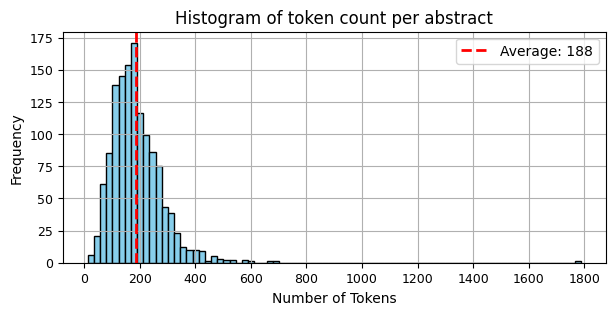

In [3]:
# Calculate token count for each abstract
df['token_count'] = df['abstractText'].apply(lambda x: len(word_tokenize(x)))
average_token_count = int(df['token_count'].mean())
print(len(df[df['token_count'] >= 2048]), 'abstracts exceed 2048 tokens.')

# Plotting the histogram
fig = plt.figure(figsize=(7, 3))

plt.hist(df['token_count'], bins=80, color='skyblue', edgecolor='black')
plt.axvline(average_token_count, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_token_count}')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of token count per abstract')

plt.legend(fontsize=10, loc='upper right')
plt.xticks(np.arange(0, 2000, 200), fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True)

plt.show()

<h1>Choosing K (Silhouette Score Test)</h1>

Instead of guessing "K", we will perform a Silhouette score test to determine the appropriate number of clusters that exhibits a high score. The Silhouette Score serves as a quantitative measure of the degree of separation between clusters. It ranges from -1 to 1, where scores closer to 1 indicate well-defined clusters, 0 suggests overlapping clusters, and negative values mean that data points might be assigned to the wrong cluster.

In this process, k-means will be performed multiple times, and the Silhouette score will be measured and stored for each run. After that, the scores will be plotted for each value of "K," allowing us to decide on the optimal "K" value.

<h3 style="color:blue;">Calculate scores for different values of K</h3>

In [4]:
test_range = range(2, 18) # K range

# A function that takes a list of encodings, cluster them several times using a range of K. 
# Returns a list of silhouette scores
def silhouette_score_test(encodings):
    list_silhouette_scores = []
    for i in test_range:
        kmeans = KMeans(n_clusters=i, n_init=50, random_state=3)
        kmeans.fit(encodings)
        list_silhouette_scores.append(silhouette_score(encodings, kmeans.labels_))
    return list_silhouette_scores

list_silhouette_scores = silhouette_score_test(df['encoding'].to_list())

<h3 style="color:blue;">Plot the test results</h3>

Now, take a look at the plot below. When K is 2, the Silhouette Score is at its best. However, a value of 2 is not optimal because I'm convinced that there exist more diversity in the topics than 2 clusters (even k=1 is going to result in a perfect Silhouette score of 1, but it doesn't make sense to choose that value). It is important to highlight that the selection of the optimal value is not solely based on the highest score but also involves consideration of the entire plot's shape in addition to some domain knowledge.

After experimenting with different values, I've decided to proceed with K=12 clusters since it exhibits a score of around 0.1 which is relatively high and allows us to identify 12 distinct clusters.

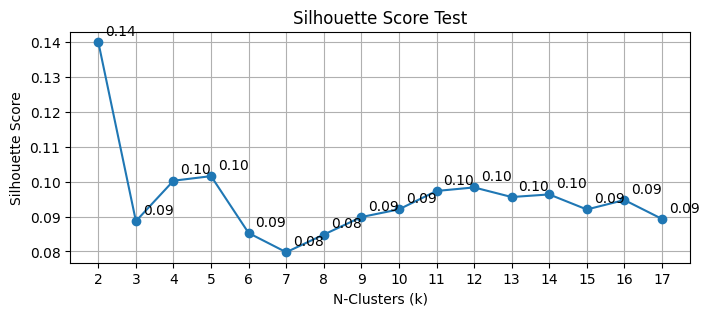

In [5]:
fig = plt.figure(figsize=(8, 3))

# Plot silhouette scores
plt.plot(test_range, list_silhouette_scores, marker='o')

# Annotate each point with the silhouette score
for i, score in zip(test_range, list_silhouette_scores):
    plt.annotate(f'{score:.2f}', xy=(i, score), xytext=(5, 5), textcoords='offset points')
    
plt.title('Silhouette Score Test')
plt.xlabel('N-Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(test_range)
plt.grid(True)
plt.show()

<h1>Clustering</h1>

<h3 style="color:blue;">Perform the clustering with the optimal K</h3>

Now that we've decided on the value of K, it's time to perform the actual clustering of the encodings:

In [6]:
# Specify K chosen in the previous step
optimal_n_clusters = 12

In [7]:
encodings = df['encoding'].to_list()
keywords = df['keywords'].to_list()

# Run k-means
kmeans = KMeans(n_clusters=optimal_n_clusters,
                n_init=50,
                random_state=3
               ).fit(encodings)

<h3 style="color:blue;">Calculate most frequent keywords per cluster</h3>

Now that we have performed the clustering, we will calculate the most frequent keywords from each cluster. This will help us determine the topic that characterizes each cluster.

In [8]:
# Function that returns the most frequent keywords per cluster
def most_freq_keywords(labels, keywords, top_N):
    
    df_cluster_keyword = pd.DataFrame({
        'cluster': list(labels),
        'keywords': keywords
    })

    df_cluster_keyword = df_cluster_keyword.groupby('cluster')['keywords'].sum().reset_index()

    # Initialize an empty dictionary to store the top N most repeated words for each cluster
    top_N_repeated_words_by_cluster = {}

    # Group the DataFrame by 'cluster' and find the top N most repeated words for each cluster
    for cluster, group in df_cluster_keyword.groupby('cluster'):
        all_keywords = [word for sublist in group['keywords'] for word in sublist]
        word_counts = Counter(all_keywords)
        top_repeated_words = [word for word, count in word_counts.most_common(top_N)]
        top_N_repeated_words_by_cluster[cluster] = top_repeated_words

    top_N_repeated_words_by_cluster = pd.DataFrame(top_N_repeated_words_by_cluster.items(), columns=['cluster', 'keywords'])
    
    return top_N_repeated_words_by_cluster

df_cluster_keywords = most_freq_keywords(kmeans.labels_, keywords, top_N = 6)
df_cluster_keywords

,cluster,keywords
0,0,"[polishing, optical, optics, machining, magnetorheological, surfaces]"
1,1,"[renewable, electricity, solar, energy, photovoltaics, photovoltaic]"
2,2,"[melanoma, rna, macrophages, myelin, cells, genes]"
3,3,"[health, digital, tourist, biomimetics, tourism, participatory]"
4,4,"[metabolic, training, aerobic, motivation, prostate, biopsy]"
5,5,"[dielectric, silicon, nanowires, carbon, plasma, electrode]"
6,6,"[classification, classifier, classifiers, kernel, statistical, prediction]"
7,7,"[quality, 3d, video, stereoscopic, visual, 3dtv]"
8,8,"[virtualization, network, recommender, virtual, data, iot]"
9,9,"[uncertainty, piezoelectric, reactor, buckling, damping, vibration]"


<h3 style="color:blue;">Assign cluster topics</h3>

Based on the most frequent keywords and random data checks, I've mapped the clusters to their most suitable disciplines as follows:

In [9]:
# Dictionary for cluster-topic mapping
cluster_topic_mapping = {
    0: 'Optical Engineering', # [polishing, optical, optics, machining, magnetorheological, surfaces]
    1: 'Energy', # [renewable, electricity, solar, energy, photovoltaics, photovoltaic]
    2: 'Biology', # [melanoma, rna, macrophages, myelin, cells, genes]
    3: 'Social Sciences',  # [health, digital, tourist, biomimetics, tourism, participatory]
    4: 'Health', # [metabolic, training, aerobic, motivation, prostate, biopsy]
    5: 'Electronics', # [dielectric, silicon, nanowires, carbon, plasma, electrode]
    6: 'Machine Learning & Big Data', # [classification, classifier, classifiers, kernel, statistical, prediction]
    7: 'Multimedia', # [quality, 3d, video, stereoscopic, visual, 3dtv]
    8: 'Networking', # [virtualization, network, recommender, virtual, data, iot]
    9: 'Structural Engineering',  # [uncertainty, piezoelectric, reactor, buckling, damping, vibration]
    10: 'Semiconductors', # [quantum, magnetic, photoluminescence, semiconductor, exciton, polaron]
    11: 'Nanotechnology',  # [optical, laser, ghz, fpga, waveguide, waveguides]
}

# Map the 'cluster' column to a new 'topic' column using the dictionary
df_cluster_keywords['topic'] = df_cluster_keywords['cluster'].map(cluster_topic_mapping)

# color palette
palette = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#663300', '#A65628', '#03fce8', '#fc03be', '#7ef542', '#FFD700', '#fc8d8d']

# Mapping cluster to colors
cluster_to_color = {key: palette[idx] for idx, key in enumerate(cluster_topic_mapping.keys())}

# Assigning colors to the dataframe based on the cluster
df_cluster_keywords['color'] = df_cluster_keywords['cluster'].map(cluster_to_color)

df_cluster_keywords

,cluster,keywords,topic,color
0,0,"[polishing, optical, optics, machining, magnetorheological, surfaces]",Optical Engineering,#E41A1C
1,1,"[renewable, electricity, solar, energy, photovoltaics, photovoltaic]",Energy,#377EB8
2,2,"[melanoma, rna, macrophages, myelin, cells, genes]",Biology,#4DAF4A
3,3,"[health, digital, tourist, biomimetics, tourism, participatory]",Social Sciences,#984EA3
4,4,"[metabolic, training, aerobic, motivation, prostate, biopsy]",Health,#FF7F00
5,5,"[dielectric, silicon, nanowires, carbon, plasma, electrode]",Electronics,#663300
6,6,"[classification, classifier, classifiers, kernel, statistical, prediction]",Machine Learning & Big Data,#A65628
7,7,"[quality, 3d, video, stereoscopic, visual, 3dtv]",Multimedia,#03fce8
8,8,"[virtualization, network, recommender, virtual, data, iot]",Networking,#fc03be
9,9,"[uncertainty, piezoelectric, reactor, buckling, damping, vibration]",Structural Engineering,#7ef542


<h3 style="color:blue;">Examine a sample after assigning the topics</h3>

In [10]:
# Assign cluster labels to the main df
df['cluster'] = kmeans.labels_

# Map clusters to topic names
df['topic'] = df['cluster'].map(cluster_topic_mapping)

# Function to sample 3 titles from each topic group
def sample_titles(group, n=3):
    return group.sample(n=min(n, len(group)))

# Group by 'Topic' and apply the sampling function
df_sample = df.groupby('topic').apply(lambda x: sample_titles(x, 3)).reset_index(drop=True)
df_sample[['topic', 'title']]

,topic,title
0,Biology,"3D hydrogel-based microcapsules as an in vitro model to study tumorigenicity, cell migration and..."
1,Biology,Immune cells contribute to myelin degeneration and axonopathic changes in mice overexpressing pr...
2,Biology,Molecular Changes Induced in Melanoma by Cell Culturing in 3D Alginate Hydrogels
3,Electronics,"Properties of atomic-vapor and atomic-layer deposited Sr, Ti, and Nb doped Ta2O5 Metal–Insulator..."
4,Electronics,Treatment with orthophosphoric acid enhances the thermal stability of the piezoelectricity in lo...
5,Electronics,Magnetic and superconducting nanowires
6,Energy,Effects of large scale EV and PV integration on power supply systems in the context of Singapore
7,Energy,"Technical, Economical and Social Assessment of Photovoltaics in the Frame of the Net-Metering La..."
8,Energy,Modeling start-up times in unit commitment by limiting temperature increase and heating
9,Health,Gender-linked determinants for utilization of long-term care in community-dwelling adults 65+ in...


<h3 style="color:blue;">Plot the clustering results</h3>

Since the hidden size of the encodings coming from the model is in a very high-dimensional space (768 dimensions), we need to use a dimensionality reduction technique such as UMAP (Uniform Manifold Approximation and Projection). UMAP is specifically designed for visualizing high-dimensional data in a lower-dimensional space while preserving the underlying manifold structure and maintaining meaningful relationships between points. Be aware that if you re-run UMAP, you'll get different plots each time because the reduction algorithm involves a degree of randomness, but you'll still get a reasonable plot showing the relative distances between data points. Also, don't worry about data points that appear far from their cluster or sometimes in the middle of the wrong cluster. This is a consequence of any reduction technique, where some information loss occurs due to the reduction process.

In addition to the Silhouette Score, I'm including two other metrics to evaluate clustering quality: Calinski-Harabasz and Davies-Bouldin. The Calinski-Harabasz Index measures the ratio of between-cluster variance to within-cluster variance, indicating well-separated and compact clusters with higher values. The Davies-Bouldin Index measures the average similarity between each cluster and its most similar cluster, aiming for lower values that suggest more distinct clusters. Including these three metrics is useful for benchmarking in case you decided to extend this analysis and use different models or techniques.

Now let's look at the visual results:

In [11]:
import textwrap
# Define a function to check for overlap between labels in the plot (to avoid having labels covering the ones nearby)
def is_overlapping(label, labels):
    for existing_label in labels:
        if label.get_window_extent().overlaps(existing_label.get_window_extent()):
            return True
    return False

# Define a function to plot the encodings
def plot_encodings(encodings,
                    title,
                    kmeans,
                    cluster_keywords):
    
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # Reduce hidden size using UMAP
    reduced_encodings = umap.UMAP(n_neighbors=15,
                               min_dist=.3,
                               metric='correlation').fit_transform(encodings)
    
    # Create a list of unique cluster numbers
    unique_clusters = list(set(labels))

    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    # Create a list to store label instances
    label_instances = []

    # Create a scatter plot for each cluster with a unique color
    for i, cluster in enumerate(unique_clusters):
        cluster_indices = [j for j, c in enumerate(labels) if c == cluster]
        cluster_keywords = df_cluster_keywords.loc[df_cluster_keywords['cluster'] == cluster, 'keywords'].values[0]
        cluster_topic = df_cluster_keywords.loc[df_cluster_keywords['cluster'] == cluster, 'topic'].values[0]
        cluster_color = df_cluster_keywords.loc[df_cluster_keywords['cluster'] == cluster, 'color'].values[0]

        # Plot the reduced encodings
        plt.scatter(reduced_encodings[cluster_indices, 0], reduced_encodings[cluster_indices, 1], label=f'{cluster_topic}: {cluster_keywords}', color=cluster_color, s=8)

        # Calculate the center of the cluster (for the label in the middle)
        center_x, center_y = np.mean(reduced_encodings[cluster_indices, 0]), np.mean(reduced_encodings[cluster_indices, 1])
        label_text = f'{cluster_topic}'

        label_max_width = 14  # Maximum width in characters

        # Wrap the text
        wrapped_text = "\n".join(textwrap.wrap(label_text, label_max_width))

        # Add labels with a white background
        label = plt.text(center_x, center_y, wrapped_text, fontsize=8, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=.9))

        # Check for overlap and adjust label position if necessary
        step_size = 0.05
        while is_overlapping(label, label_instances):
            center_x += step_size
            center_y += step_size
            label.set_position((center_x, center_y))

        label_instances.append(label)

    # Calculate clustering scores
    silhouette = silhouette_score(encodings, labels)
    Calinski_Harabasz = calinski_harabasz_score(encodings, labels)
    davies_bouldin = davies_bouldin_score(encodings, labels)
    
    # Add clustering scores right next to the plot
    plt.text(max(reduced_encodings[:,0]+2),
             sum(reduced_encodings[:,1])/len(reduced_encodings),
             'Clustering Scores:\n'
             + '\nSilhouette Score = '+str(round(silhouette, 3))
             + '\nCalinski-Harabasz = '+str(round(Calinski_Harabasz, 3))
             + '\nDavies-Bouldin = '+str(round(davies_bouldin, 3)),
             fontsize=12,
             ha='left', va='top')

    # Add legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=1, markerscale=3);

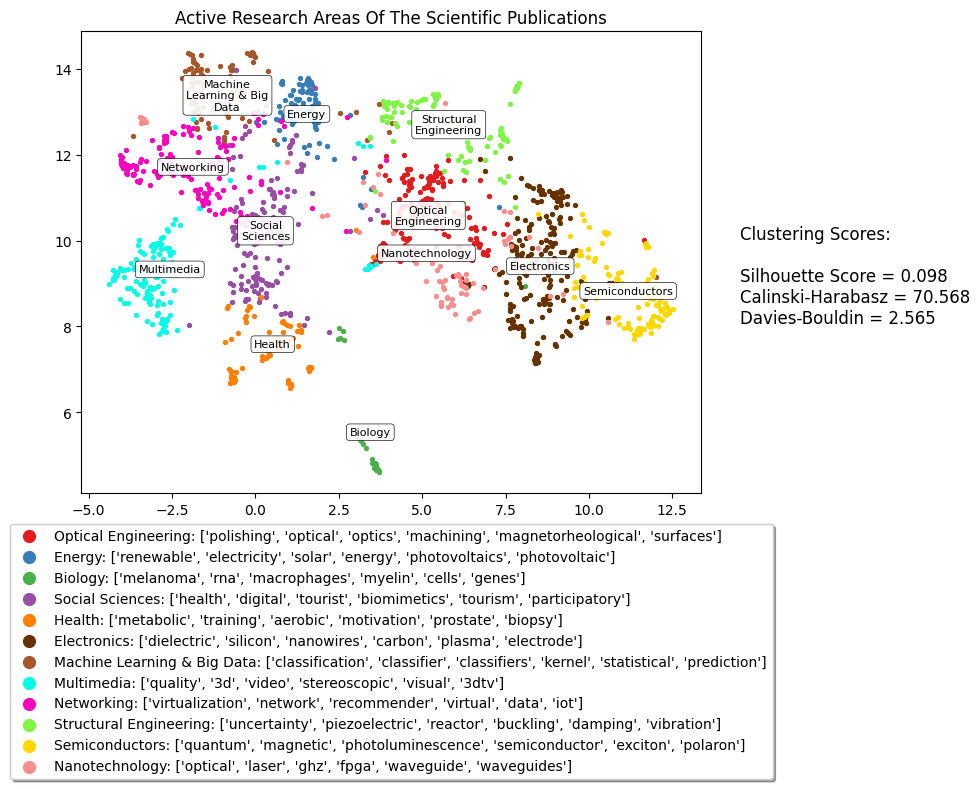

In [14]:
# Plot the clustering results
plot_encodings(encodings,
               title= 'Active Research Areas Of The Scientific Publications',
               kmeans=kmeans,
               cluster_keywords=df_cluster_keywords);

Let's summarize the dominant research areas in a pie chart:

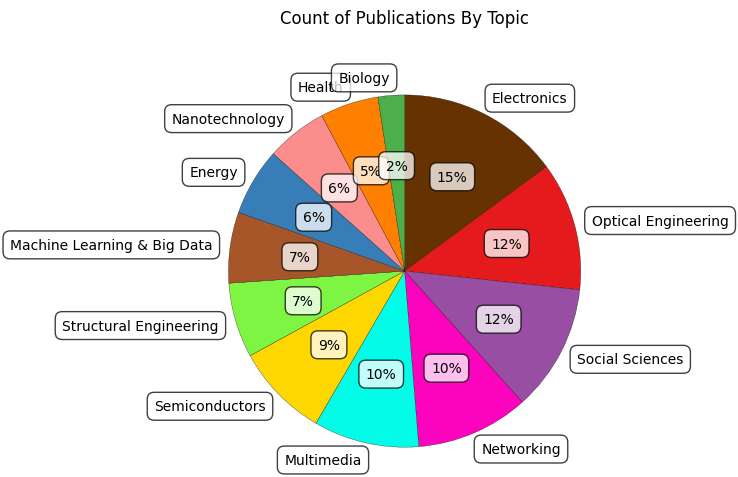

In [13]:
df_counts = pd.DataFrame({
    'cluster': kmeans.labels_
})

# Convert the list to a pandas Series
series = pd.Series(kmeans.labels_)

# Group by values and count occurrences
df_counts = series.groupby(series).size().reset_index(name='count')
df_counts = pd.merge(df_cluster_keywords, df_counts, left_on='cluster', right_on='index')

# Sort by count in descending order
df_counts = df_counts.sort_values(by='count', ascending=False)

plt.figure(figsize=(5, 5))
plt.pie(df_counts['count'],
        labels=df_counts['topic'],
        colors=df_counts['color'],
        autopct='%1.0f%%',
        startangle=90,
        counterclock=False,
        wedgeprops={'edgecolor': 'black', 'linewidth': .2},
        textprops={'bbox': dict(facecolor='white', alpha=0.75, edgecolor='black', boxstyle='round,pad=0.5')})

plt.axis('equal') 
plt.title('Count of Publications By Topic', pad=40)

plt.show()

<h1>Results Discussion</h1>

The results of this analysis demonstrate diversity within the library, with no single discipline or field of study dominating the research area. However, there appears to be some extra focus on topics related to physical matter or manufacturing, as evidenced by clusters like Electronics, Optical Engineering, Semiconductors, and Nanotechnology. If you revisit the scatter plot, you'll notice that the data points split into two larger groups, with the right-hand group primarily involving physical matter. On the other hand, the left-hand group relies largely on data or computer science techniques. It's quite fascinating, isn't it? This phenomenon explains why the Silhouette score was high when K=2. However, our goal was to break down these two big clusters into more detailed topics.

Computer science-related topics like Machine Learning & Big Data, Networking, and Multimedia also have a strong presence. I would expect that these areas will continue to evolve given the increasing number of programs and opportunities offered in recent years.

Health and Biology represent the smallest portion of research activity, which aligns with the institution's focus on technology.

Regarding cluster quality, while there is room for improvement in scores, as long as the analysis provides a satisfactory overall answer, our goal is achieved. It's worth noting that clustering algorithms like k-means struggle in high-dimensional spaces, negatively affecting their performance. Addressing this issue could involve reducing the dimensionality of encodings before clustering, using techniques such as autoencoders, which may be explored in future contributions. 😊

<h1>Conclusion</h1>

In this analysis, we've employed transformer models to conduct Topic Modeling on a dataset of scientific publications from the Deggendorf Institute of Technology in an unsupervised setting. Through this approach, we identified 12 active research areas within the publication database.

This solution provides a sufficient response to our research question: "What are the most active research areas within the publications database?" However, there is always room for further exploration and improvement. Given the unsupervised nature of the analysis, interpretations may improve with additional exploration. Feel free to use this solution as a foundation for further analysis and enhancements!